
## Load fes2014 currents and plot statistics


In [1]:
%matplotlib inline
#import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset

datadir='/home2/pharos/othr/aponte/tides/FES2014/'
uvdir = datadir+'fes2014a_currents/'

In [2]:
# load uv for one constituent

class tdata():
    
    def __init__(self,cst):
        self.cst = cst
        #
        fname = uvdir+'eastward_velocity/'+cst+'.nc'
        print 'Load from '+fname
        #
        nc = Dataset(uvdir+'eastward_velocity/'+cst+'.nc','r')
        self.u_a = nc.variables['Ua'][:]
        self.u_g = nc.variables['Ug'][:]    
        self.lon = nc.variables['lon'][:]
        self.lat = nc.variables['lat'][:]
        nc.close()
        #
        nc = Dataset(uvdir+'northward_velocity/'+cst+'.nc','r')
        self.v_a = nc.variables['Va'][:]
        self.v_g = nc.variables['Vg'][:]    
        #self.v_lon = nc.variables['lon'][:]
        #self.v_lat = nc.variables['lat'][:]
        nc.close()
        
    def load_bathy(self,b='etopo2'):
        ''' Load bathymetry
        '''
        interp = False
        #
        if b is 'etopo2':
            bfile = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
            nc = Dataset(bfile)
            lonb = nc.variables['x'][:]
            latb = nc.variables['y'][:]
            hb = nc.variables['z'][:]
            nc.close()
            interp = True
        if interp:
            from scipy.interpolate import interp2d, RectBivariateSpline
            #lonb, latb = np.meshgrid(lonb,latb)
            #self.h = interp2d(lonb, latb, hb.T, kind='linear')(self.lon,self.lat)
            iroll = np.where(lonb<0)[0][-1]+1
            lonb = np.roll(lonb,-iroll)
            hb = np.roll(hb,-iroll,axis=1)
            lonb[lonb<0] = lonb[lonb<0] + 360.
            self.h = RectBivariateSpline(lonb, latb, hb.T, kx=1, ky=1)(self.lon,self.lat).T
        else:
            self.h = hb
        print lonb
        print self.lon
            
        
%time M2 = tdata('m2')
%time M2.load_bathy()


Load from /home2/pharos/othr/aponte/tides/FES2014/fes2014a_currents/eastward_velocity/m2.nc
CPU times: user 80.3 ms, sys: 124 ms, total: 204 ms
Wall time: 204 ms
[  1.66666675e-02   5.00000007e-02   8.33333358e-02 ...,   3.59916656e+02
   3.59950012e+02   3.59983337e+02]
[  0.00000000e+00   6.25000000e-02   1.25000000e-01 ...,   3.59812500e+02
   3.59875000e+02   3.59937500e+02]
CPU times: user 7.62 s, sys: 692 ms, total: 8.31 s
Wall time: 8.43 s


/home1/homedir5/perso/aponte/.miniconda2/envs/natl60/lib/python2.7/site-packages/numpy/ma/core.py:6164: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


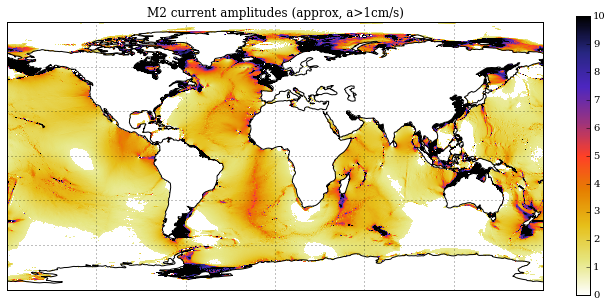

In [3]:
### plot a map of current amplitudes

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
toplt = np.sqrt(M2.u_a**2+M2.v_a**2)
toplt[toplt<1.] = 0.
#toplt = np.log10(toplt)
hdl = ax.pcolormesh(M2.lon,M2.lat,toplt,vmax=10., \
                    transform = ccrs.PlateCarree(),cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
plt.colorbar(hdl,ax=ax)
ax.set_title('M2 current amplitudes (approx, a>1cm/s)')
plt.show()

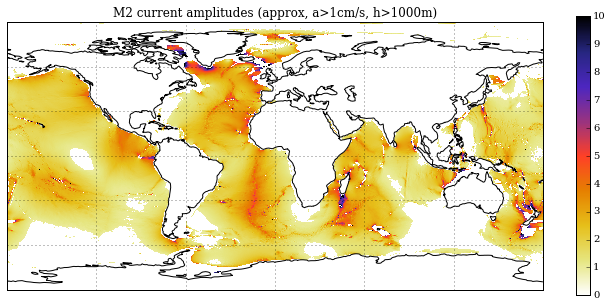

In [4]:
### same but with coastal areas masked

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
toplt = np.sqrt(M2.u_a**2+M2.v_a**2)
toplt[toplt<1.] = 0.
toplt[M2.h>-1000] = 0.
#toplt = np.log10(toplt)
hdl = ax.pcolormesh(M2.lon,M2.lat,toplt,vmax=10., \
                    transform = ccrs.PlateCarree(),cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
plt.colorbar(hdl,ax=ax)
ax.set_title('M2 current amplitudes (approx, a>1cm/s, h>1000m)')
plt.show()

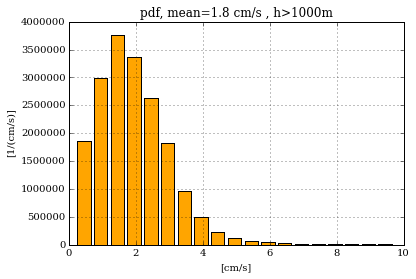

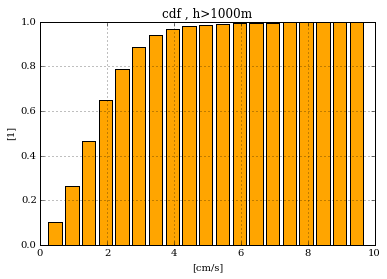

In [5]:
### plot histogram of amplitudes

bins_e = np.arange(0.,10.,.5)
A = np.sqrt(M2.u_a**2+M2.v_a**2)
A = A[np.where(M2.h<-1000.)]
M2.uv_hist,bins_e = np.histogram(A,bins=bins_e,density=False)
bins_c = (bins_e[:-1]+bins_e[1:])*.5
M2.uv_pdf = M2.uv_hist/np.diff(bins_e)
M2.uv_cdf = np.cumsum(M2.uv_hist)/float(A.size)

plt.figure()
ax = plt.gca()
#ax.bar(bins_c,np.log10(M2.uv_pdf),color='orange',width=.4)
ax.bar(bins_c,M2.uv_pdf,color='orange',width=.4)
ax.set_xlabel('[cm/s]')
ax.set_title('pdf, mean=%.1f cm/s , h>1000m' %(A.mean()))
ax.set_ylabel('[1/(cm/s)]')
ax.grid()


plt.figure()
ax = plt.gca()
ax.bar(bins_c,M2.uv_cdf,color='orange',width=.4)
ax.set_xlabel('[cm/s]')
ax.set_title('cdf , h>1000m')
ax.set_ylabel('[1]')
ax.grid()





In [6]:
### histogram as a function of latitude
bins_e = np.arange(0.,10.,.1)
bins_c = (bins_e[:-1]+bins_e[1:])*.5

A = np.sqrt(M2.u_a**2+M2.v_a**2)
A[M2.h>-1000] = np.NaN

uv_pdf = np.zeros((A.shape[0],bins_c.size))
uv_cdf = np.zeros((A.shape[0],bins_c.size))
uv_mean = np.zeros(A.shape[0])
for i in xrange(A.shape[0]):
    lA = A[i,:]
    lA = lA[~np.isnan(lA)]
    if lA.size>0:
        hist, bins_e = np.histogram(lA,bins=bins_e, density=False)
        uv_pdf[i,:] = hist/np.diff(bins_e)
        uv_cdf[i,:] = np.cumsum(hist)/float(lA.size)
        #uv_cdf[i,:] = np.cumsum(hist)/float(lA[~np.isnan(lA)].size)
        uv_mean[i] = np.nanmean(lA)


/home1/homedir5/perso/aponte/.miniconda2/envs/natl60/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home1/homedir5/perso/aponte/.miniconda2/envs/natl60/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


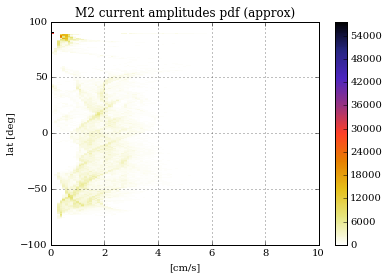

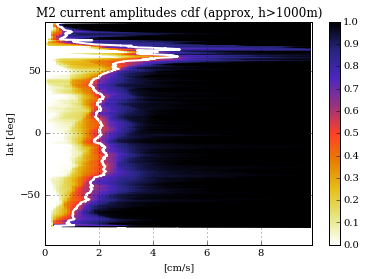

In [7]:
plt.figure()
ax = plt.gca()
hdl = ax.pcolormesh(bins_c,M2.lat,uv_pdf,cmap=plt.get_cmap('CMRmap_r'))
ax.grid()
plt.colorbar(hdl,ax=ax)
ax.set_title('M2 current amplitudes pdf (approx)')
ax.set_xlabel('[cm/s]')
ax.set_ylabel('lat [deg]')
plt.show()

plt.figure()
ax = plt.gca()
hdl = ax.pcolormesh(bins_c,M2.lat,uv_cdf,vmin=0.,cmap=plt.get_cmap('CMRmap_r'))
ax.plot(uv_mean,M2.lat,color='w',lw=2)
ax.set_xlim((0.,bins_e[-1]))
ax.set_ylim((M2.lat[0],M2.lat[-1]))
ax.grid()
plt.colorbar(hdl,ax=ax)
ax.set_title('M2 current amplitudes cdf (approx, h>1000m)')
ax.set_xlabel('[cm/s]')
ax.set_ylabel('lat [deg]')
plt.show()

